In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(1)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
import time as time
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point_gaussian
import scipy.stats as st
# from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

2024-04-14 00:31:00.791958: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Function Definitions

In [4]:
def find_coverage_calib(y, y_noisy, sigmas, ci, flag=False):
    alpha = 1 - ci                  # size = len(ci)
    k = st.norm.ppf(1 - alpha / 2)  # size = len(ci)
    q_hats = []
    times = []
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            print('-----------')
            print(lower)
            print(upper)
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
            print(coverage[i])
            print('-----------')

    else:
        for i in range(len(ci)):
            # tb = time.time()
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                q_hats.append(0)
                continue
            initial_upper = y_noisy + k[i] * sigmas
            initial_lower = y_noisy - k[i] * sigmas
            upper_err = np.array(y).reshape(-1) - \
                np.array(initial_upper).reshape(-1)
            lower_err = np.array(initial_lower).reshape(-1) - \
                np.array(y).reshape(-1)
            E_i = np.max(np.vstack((lower_err, upper_err)), axis=0)
            # E_i = []
            # for j in range(len(y)):
            #     E_i.append(
            #         max(y_noisy[j] - initial_upper[j], initial_lower[j] - y_noisy[j]))

            q_level = np.ceil((len(y)+1)*ci[i])/len(y)
            # print("q_level: ", q_level)
            q_hat = np.quantile(E_i, q_level, method='higher')
            q_hats.append(q_hat)
            upper = initial_upper + q_hat
            lower = initial_lower - q_hat
            # ta = time.time()
            # times.append(ta-tb)
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
            # check if 0 is in ci array and if so, set coverage to 0 at that index

    return coverage, q_hats, times

In [5]:
def find_coverage_train_test(y, y_noisy, sigmas, ci, q_hats, flag=False):
    alpha = 1 - ci                  # size = len(ci)
    k = st.norm.ppf(1 - alpha / 2)  # size = len(ci)
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                continue
            upper = y_noisy + k[i] * sigmas + q_hats[i]
            lower = y_noisy - k[i] * sigmas - q_hats[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
            # check if 0 is in ci array and if so, set coverage to 0 at that index

    return coverage, q_hats

In [6]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

# Model Training

In [7]:
train = {
    1: {
        'start_time': "2011-04-28",
        'end_time': "2011-05-15"
    },
    2: {
        'start_time': "2011-04-21",
        'end_time': "2011-05-21"
    }
}
test = {
    3: {
        'start_time': "2011-04-19",
        'end_time': "2011-05-22"
    }
}
appliances = ["Microwave"]

In [8]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [9]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[
    :, 0]
calibration_predictions_df['Ground Truth'] = scaler_y.inverse_transform(y_cal)[
    :, 0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test

In [10]:
model = seq2point_gaussian.seq2point()

In [11]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=50)

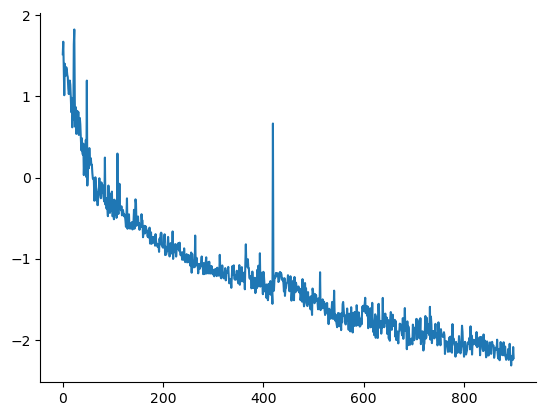

In [12]:
plt.plot(losses)
sns.despine()

In [13]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 10.2 s'

# Before Calibration

##### Results on Calibration Set

In [14]:
%%capture cap
%%time
y_hat = model.apply(params, x_cal, True, rngs={
                    "dropout": jax.random.PRNGKey(0)})

In [15]:
cal_mean = scaler_y.inverse_transform(y_hat[0])
cal_sigma = scaler_y.scale_*y_hat[1]
y_true_cal = scaler_y.inverse_transform(y_cal)

In [16]:
print(f"RMSE : {errors.rmse(y_true_cal, cal_mean):.4f} MAE  : {errors.mae(y_true_cal, cal_mean):.4f} NLL : {errors.NLL(cal_mean,cal_sigma,y_true_cal):.4f}")

RMSE : 108.8065 MAE  : 14.3864 NLL : 2.6650


In [17]:
mlp_calibration_time = cap.stdout.split('\n')[1]
mlp_calibration_time

'Wall time: 963 ms'

##### Results on Training Set

In [18]:
y_hat_train = model.apply(params, x_train, True, rngs={
    "dropout": jax.random.PRNGKey(0)})

In [19]:
train_mean = scaler_y.inverse_transform(y_hat_train[0])
train_sigma = scaler_y.scale_*y_hat_train[1]
y_train_scaled = scaler_y.inverse_transform(y_train)

In [20]:
print(f"RMSE : {errors.rmse(y_train_scaled, train_mean):.4f} MAE  : {errors.mae(y_train_scaled, train_mean):.4f} NLL : {errors.NLL(train_mean,train_sigma,y_train_scaled):.4f}")

RMSE : 97.4241 MAE  : 12.4680 NLL : 2.6448


##### Results on Test Set

In [21]:
%%capture cap
%%time
y_hat_test = model.apply(params, x_test, True, rngs={
    "dropout": jax.random.PRNGKey(0)})

In [22]:
test_mean = scaler_y.inverse_transform(y_hat_test[0])
test_sigma = scaler_y.scale_*y_hat_test[1]

In [23]:
print(f"RMSE : {errors.rmse(y_test, test_mean):.4f} MAE  : {errors.mae(y_test, test_mean):.4f} NLL : {errors.NLL(test_mean,test_sigma,y_test):.4f}")

RMSE : 79.3276 MAE  : 11.6162 NLL : 16.5683


In [24]:
mlp_testing_time = cap.stdout.split('\n')[1]
mlp_testing_time

'Wall time: 1.12 s'

# After Calibration

### Conformal Prediction

##### Results on Calibration Set

In [25]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_cal, _, _ = find_coverage_calib(
    y_true_cal, cal_mean, cal_sigma, ci)

-----------
[[ 4.990208 ]
 [ 4.9056735]
 [11.474905 ]
 ...
 [ 5.8475833]
 [ 5.372638 ]
 [ 4.8783746]]
[[ 4.990208 ]
 [ 4.9056735]
 [11.474905 ]
 ...
 [ 5.8475833]
 [ 5.372638 ]
 [ 4.8783746]]
0.0
-----------
-----------
[[4.8776464]
 [4.807739 ]
 [5.084488 ]
 ...
 [5.739018 ]
 [5.2948494]
 [4.7944016]]
[[ 5.10277  ]
 [ 5.003608 ]
 [17.865322 ]
 ...
 [ 5.9561486]
 [ 5.450427 ]
 [ 4.9623475]]
0.0781516507267952
-----------
-----------
[[ 4.763271 ]
 [ 4.7082267]
 [-1.4088793]
 ...
 [ 5.628703 ]
 [ 5.215807 ]
 [ 4.7090755]]
[[ 5.2171454]
 [ 5.1031203]
 [24.358688 ]
 ...
 [ 6.0664635]
 [ 5.5294695]
 [ 5.0476737]]
0.21367652714252472
-----------
-----------
[[ 4.6450553]
 [ 4.6053724]
 [-8.120289 ]
 ...
 [ 5.5146847]
 [ 5.134111 ]
 [ 4.6208844]]
[[ 5.335361 ]
 [ 5.2059746]
 [31.070099 ]
 ...
 [ 6.180482 ]
 [ 5.6111655]
 [ 5.1358647]]
0.32919830083847046
-----------
-----------
[[  4.5204735]
 [  4.49698  ]
 [-15.193106 ]
 ...
 [  5.394526 ]
 [  5.048015 ]
 [  4.527944 ]]
[[ 5.459943 ]
 [ 5.

In [26]:
initial_coverages_cal

array([0.        , 0.07815165, 0.21367653, 0.3291983 , 0.43572643,
       0.53791285, 0.63095051, 0.72832996, 0.84524727, 0.9468134 ,
       0.99999994])

In [27]:
%%capture cap
%%time
flag = True
final_coverages_cal, q_hats, times = find_coverage_calib(
    y_true_cal, cal_mean, cal_sigma, ci, flag=flag)

In [28]:
final_coverages_cal

array([0.        , 0.10017057, 0.20018606, 0.30020157, 0.40021706,
       0.50023258, 0.6002481 , 0.70026356, 0.80027908, 0.9002946 ,
       1.        ])

In [29]:
q_hats

[0,
 0.15930128,
 -0.08413601,
 -0.117816925,
 -0.12678385,
 -0.12885618,
 -0.09022045,
 -0.06010008,
 -0.085721016,
 -0.1442995,
 0]

In [30]:
conformal = cap.stdout.split('\n')[1]
conformal

'Wall time: 113 ms'

In [31]:
ace_init_cal, ece_init_cal = calib_errors(ci, initial_coverages_cal)
ace_fin_cal, ece_fin_cal = calib_errors(ci, final_coverages_cal)

In [32]:
print('Calibration:')
print(f'Initial ace error is {ace_init_cal} and ece error is {ece_init_cal}')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Initial ace error is 0.289703656733036 and ece error is 0.026336696066639635
Final ace error is 0.0020931661128997525 and ece error is 0.00019028782844543205


##### Results on Training Set

In [33]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_train, _ = find_coverage_train_test(
    y_train_scaled, train_mean, train_sigma, ci, [])
initial_coverages_train

array([0.        , 0.07888343, 0.21876453, 0.33279917, 0.44192296,
       0.54272419, 0.63303179, 0.72437322, 0.83763248, 0.94044971,
       1.        ])

In [34]:
q_hats

[0,
 0.15930128,
 -0.08413601,
 -0.117816925,
 -0.12678385,
 -0.12885618,
 -0.09022045,
 -0.06010008,
 -0.085721016,
 -0.1442995,
 0]

In [35]:
flag = True
final_coverages_train, q_hats = find_coverage_train_test(
    y_train_scaled, train_mean, train_sigma, ci, q_hats, flag=flag)
print(final_coverages_train)

[0.         0.10152494 0.2066167  0.3024554  0.40227449 0.50400621
 0.60124063 0.69687259 0.794779   0.89159989 1.        ]


In [36]:
ace_init_train, ece_init_train = calib_errors(ci, initial_coverages_train)
ace_fin_train, ece_fin_train = calib_errors(ci, final_coverages_train)

In [37]:
print('Train:')
print(
    f'Initial ace error is {ace_init_train} and ece error is {ece_init_train}')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Initial ace error is 0.29281461685895915 and ece error is 0.02661951062354174
Final ace error is 0.03486687988042833 and ece error is 0.003169716352766212


##### Results on Test Set

In [38]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_test, _ = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, [])
initial_coverages_test

array([0.        , 0.09458728, 0.3097429 , 0.34979701, 0.37922868,
       0.39715832, 0.41224629, 0.42699593, 0.44763193, 0.47489852,
       1.        ])

In [39]:
q_hats

[0,
 0.15930128,
 -0.08413601,
 -0.117816925,
 -0.12678385,
 -0.12885618,
 -0.09022045,
 -0.06010008,
 -0.085721016,
 -0.1442995,
 0]

In [40]:
flag = True
final_coverages_test, q_hats = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, q_hats, flag=flag)
print(final_coverages_test)

[0.         0.09715832 0.30757782 0.34878215 0.37679297 0.39546683
 0.41102841 0.42503384 0.44560218 0.47212449 1.        ]


In [41]:
ace_init_test, ece_init_test = calib_errors(ci, initial_coverages_test)
ace_fin_test, ece_fin_test = calib_errors(ci, final_coverages_test)

In [42]:
print(f'Initial ace error is {ace_init_test} and ece error is {ece_init_test}')
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Initial ace error is 1.5267929583787918 and ece error is 0.13879935985261743
Final ace error is 1.5331529304385185 and ece error is 0.1393775391307744


##### Comparison of Results

In [43]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

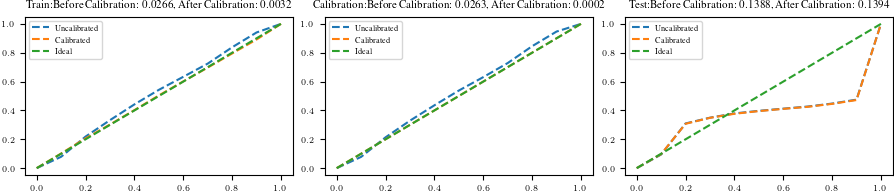

In [44]:
# Train
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (9, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, initial_coverages_train, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train:Before Calibration: {"{:.4f}".format(ece_init_train)}, After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, initial_coverages_cal, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration:Before Calibration: {"{:.4f}".format(ece_init_cal)}, After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, initial_coverages_test, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:Before Calibration: {"{:.4f}".format(ece_init_test)}, After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_Conformal_Conformal.pdf')